# 1 - DEFINE THE PROBLEM
We aim to build a classification model to predict whether a song play was the first time it was aired (`First?` column), based on data from U.S. radio classic rock airplays.

# 2 - IMPORT REQUIRED LIBRARIES

## 2.1 - Base Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

## 2.2 - ML/DL Libraries

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 3 - LOAD THE DATA

In [3]:
conn = sqlite3.connect('../datasets/classic_rock.db')
df = pd.read_sql_query('SELECT * FROM rock_plays', conn)

# 4 - EDA (Exploratory Data Analysis)

In [4]:
df.head()

,SONG RAW,Song Clean,ARTIST RAW,ARTIST CLEAN,CALLSIGN,TIME,UNIQUE_ID,COMBINED,First?,date_time,day_of_week
0,Caught Up In (live),Caught Up in You,.38 Special,.38 Special,KGLK,1402943314,KGLK1536,Caught Up in You by .38 Special,1,2014-06-16 18:28:34,0
1,Caught Up In You,Caught Up in You,.38 Special,.38 Special,KGB,1403398735,KGB0260,Caught Up in You by .38 Special,0,2014-06-22 00:58:55,6
2,Caught Up In You,Caught Up in You,.38 Special,.38 Special,KGB,1403243924,KGB0703,Caught Up in You by .38 Special,0,2014-06-20 05:58:44,4
3,Caught Up in You,Caught Up in You,.38 Special,.38 Special,KGLK,1403470732,KGLK0036,Caught Up in You by .38 Special,0,2014-06-22 20:58:52,6
4,Caught Up in You,Caught Up in You,.38 Special,.38 Special,KGLK,1403380737,KGLK0312,Caught Up in You by .38 Special,0,2014-06-21 19:58:57,5


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37673 entries, 0 to 37672
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SONG RAW      37673 non-null  object
 1   Song Clean    37647 non-null  object
 2   ARTIST RAW    37668 non-null  object
 3   ARTIST CLEAN  37665 non-null  object
 4   CALLSIGN      37673 non-null  object
 5   TIME          37673 non-null  int64 
 6   UNIQUE_ID     37673 non-null  object
 7   COMBINED      37673 non-null  object
 8   First?        37673 non-null  int64 
 9   date_time     37673 non-null  object
 10  day_of_week   37673 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 3.2+ MB
None


In [6]:
print(df.isnull().sum())

SONG RAW         0
Song Clean      26
ARTIST RAW       5
ARTIST CLEAN     8
CALLSIGN         0
TIME             0
UNIQUE_ID        0
COMBINED         0
First?           0
date_time        0
day_of_week      0
dtype: int64


In [7]:
df.describe(include='all')

,SONG RAW,Song Clean,ARTIST RAW,ARTIST CLEAN,CALLSIGN,TIME,UNIQUE_ID,COMBINED,First?,date_time,day_of_week
count,37673,37647,37668,37665,37673,3.767300e+04,37673,37673,37673.000000,37673,37673.000000
unique,3710,2158,867,476,25,NaN,37673,2231,NaN,3599,NaN
top,Dream On,Dream On,Led Zeppelin,Led Zeppelin,KSEG,NaN,KGLK1536,Dream On by Aerosmith,NaN,2014-06-19 23:54:25,NaN
freq,126,142,1363,1556,1821,NaN,1,142,NaN,267,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.403187e+09,NaN,NaN,0.059273,NaN,3.009928
std,NaN,NaN,NaN,NaN,NaN,1.730484e+05,NaN,NaN,0.236138,NaN,1.976652
min,NaN,NaN,NaN,NaN,NaN,1.402878e+09,NaN,NaN,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,1.403049e+09,NaN,NaN,0.000000,NaN,1.000000
50%,NaN,NaN,NaN,NaN,NaN,1.403194e+09,NaN,NaN,0.000000,NaN,3.000000
75%,NaN,NaN,NaN,NaN,NaN,1.403330e+09,NaN,NaN,0.000000,NaN,5.000000


# 5 - VISUALIZE THE DATA

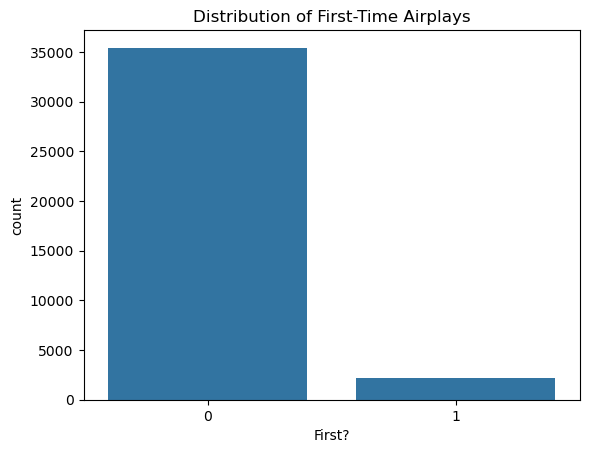

In [8]:
sns.countplot(x='First?', data=df)
plt.title('Distribution of First-Time Airplays')
plt.show()

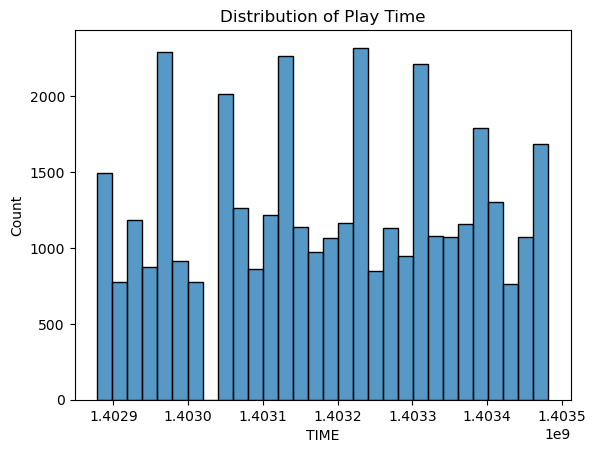

In [9]:
sns.histplot(df['TIME'], bins=30)
plt.title('Distribution of Play Time')
plt.show()

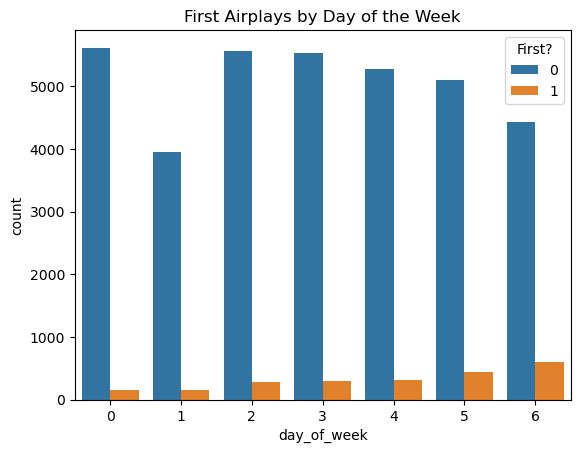

In [10]:
sns.countplot(x='day_of_week', hue='First?', data=df)
plt.title('First Airplays by Day of the Week')
plt.show()

# 6 - PREPROCESS THE DATA

In [11]:
# Drop irrelevant or leak-prone columns
X = df[['Song Clean', 'ARTIST CLEAN', 'CALLSIGN', 'day_of_week']].copy()
y = df['First?']

categorical_features = X.columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_processed = preprocessor.fit_transform(X)
print(f'✅ Processed features shape: {X_processed.shape}')

✅ Processed features shape: (37673, 2668)


# 7 - SPLIT THE DATA

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (30138, 2668), Test shape: (7535, 2668)


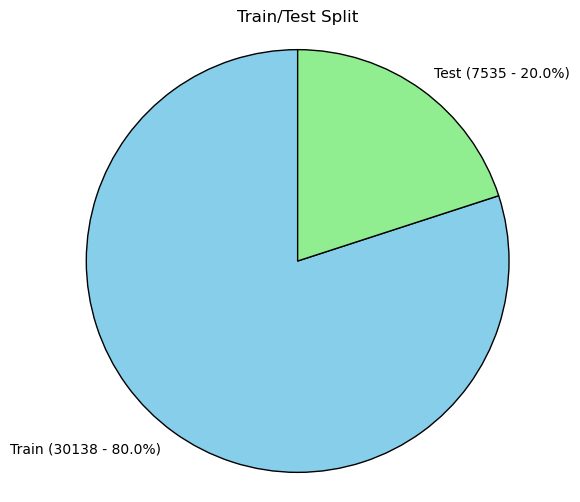

In [13]:
# Pie chart with custom labels showing both count and percentage
train_rows = X_train.shape[0]
test_rows = X_test.shape[0]
total_rows = train_rows + test_rows

labels = [
    f'Train ({train_rows} - {100 * train_rows / total_rows:.1f}%)',
    f'Test ({test_rows} - {100 * test_rows / total_rows:.1f}%)'
]
sizes = [train_rows, test_rows]

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    startangle=90,
    colors=['skyblue', 'lightgreen'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Train/Test Split')
plt.axis('equal')
plt.show()